In [1]:
from collections import defaultdict
from pathlib import Path
import re
from subprocess import call
import time

from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

from scipy import interp
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc, plot_roc_curve, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.tree import export_graphviz
from tqdm.notebook import tqdm

In [2]:
mpl.rcParams['figure.dpi'] = 150

In [3]:
MTBLS_374 = pd.read_csv("/Users/morris/Box/Hall_Lab/Projects/MTBLS_explore/MTBLS374/output/MTBLS374_preprocessedNMR_PepsNMR_extrasamplelabels_01032019.csv", index_col=0)
MTBLS_374_Metabolites = pd.read_csv("/Users/morris/Box/Hall_Lab/Projects/MTBLS_explore/MTBLS374/output/rDolphin_output/quant_02142020/quantification_rDolphin_regChemNames.csv", index_col=0)

In [78]:
X = MTBLS_374_Metabolites.iloc[:(MTBLS_374_Metabolites.shape[0]),1:(MTBLS_374_Metabolites.shape[1])]
#y = MTBLS_374_Metabolites.iloc[:(MTBLS_374_Metabolites.shape[0]),0]
# smoking
y = MTBLS_374.iloc[:(MTBLS_374.shape[0]),(MTBLS_374.shape[1]-2)]

y.head()

1      male
2      male
3    female
4      male
5      male
Name: Gender, dtype: object

In [79]:
print('X data row, cols: ', X.shape)
print('y data row, cols: ', y.shape, '\n')

X data row, cols:  (113, 79)
y data row, cols:  (113,) 



/Users/morris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/Users/morris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/Users/morris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/Users/morris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/Users/morris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/Users/morris/anaconda3/lib/python3.7/site-packages/ipy

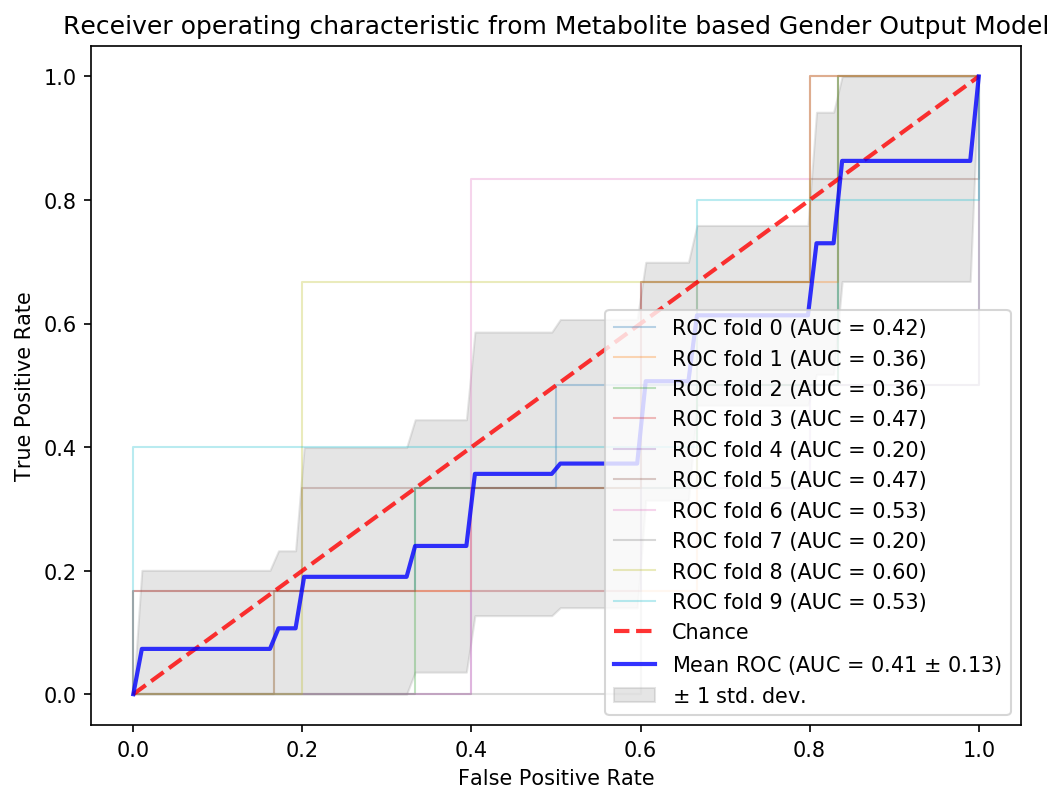

In [80]:
cv = StratifiedKFold(n_splits=10)
classifier = RandomForestClassifier(max_depth=40, n_estimators=10000, random_state=1855, n_jobs=-1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, figsize=(8, 6))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic from Metabolite based Gender Output Model")
ax.legend(loc="lower right")
plt.show()


In [7]:
yo = pd.DataFrame(y)
print(np.unique(np.asarray((y))))

['Never Smoker' 'Smoker']


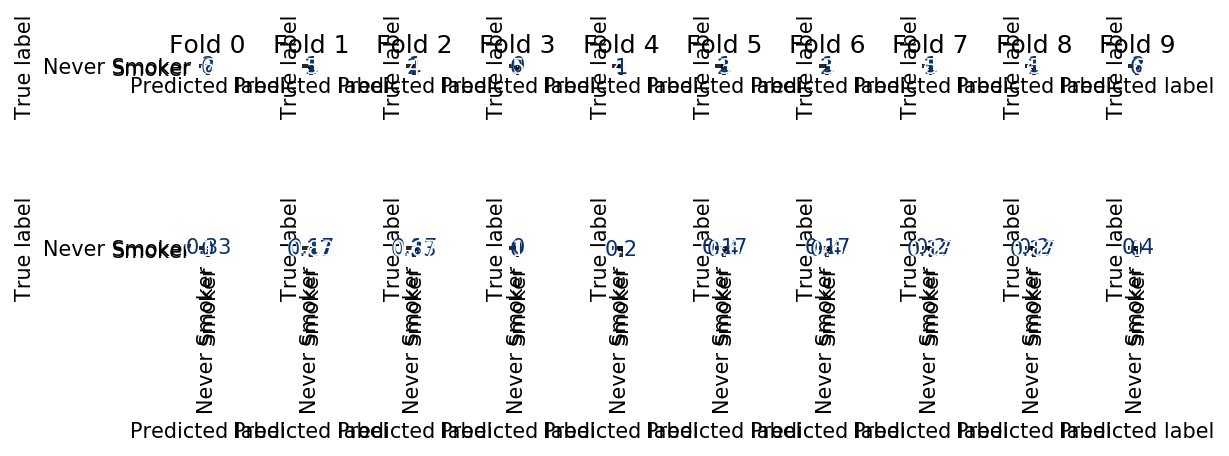

In [74]:
cv=10
clf = classifier
"""
Plot a confusion matrix for each cross-fold
"""
# Rows are Non-normalized and normalized.  Columns are each CV fold
fig, axes = plt.subplots(2, cv, figsize=(8, 4), sharex=True, sharey=True)

# Create cv object
cv_obj = StratifiedKFold(n_splits=cv)  # Note: this is the same cv approach used with 'cv=5' when scoring

for i, (train, test) in enumerate(cv_obj.split(X, y)):
    clf.fit(X.iloc[train], y.iloc[train])
    X_test = X.iloc[test]
    y_test = y.iloc[test]

    # Plot non-normalized
    plot_confusion_matrix(clf, X_test, y_test,
                          display_labels=np.unique(np.asarray((y_test))),
                          normalize=None,
                          cmap=plt.cm.Blues,
                          ax=axes[0, i],
                          xticks_rotation='vertical')
    # Plot normalized
    plot_confusion_matrix(clf, X_test, y_test,
                          display_labels=np.unique(np.asarray((y_test))),
                          normalize="true",
                          cmap=plt.cm.Blues,
                          ax=axes[1, i],
                          xticks_rotation='vertical')

# Remove axes not in the subplot- these are the colorbars that clutter the image
for a in fig.axes:
    if a not in axes:
        plt.delaxes(a)

# Label the columns of plots
for i in range(cv):
    axes[0, i].set_title(f"Fold {i}")

plt.tight_layout()

In [75]:
clf = classifier
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz
#import graphviz
# Export as dot file
export_graphviz(estimator, out_file='MTBLS374_tree.dot', 
                feature_names = list(X.columns.values),
                class_names = np.unique(np.asarray((y))),
                rounded = True,
                proportion = True,
                label = 'all',
                node_ids = False, #no
                precision = 2,
                filled = True, #no
                rotate =True, #no
                impurity=True) #no

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'MTBLS374_tree.dot', '-o', 'MTBLS374_tree.png', '-Gdpi=600'])
plt.show()
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'MTBLS374_tree.png')

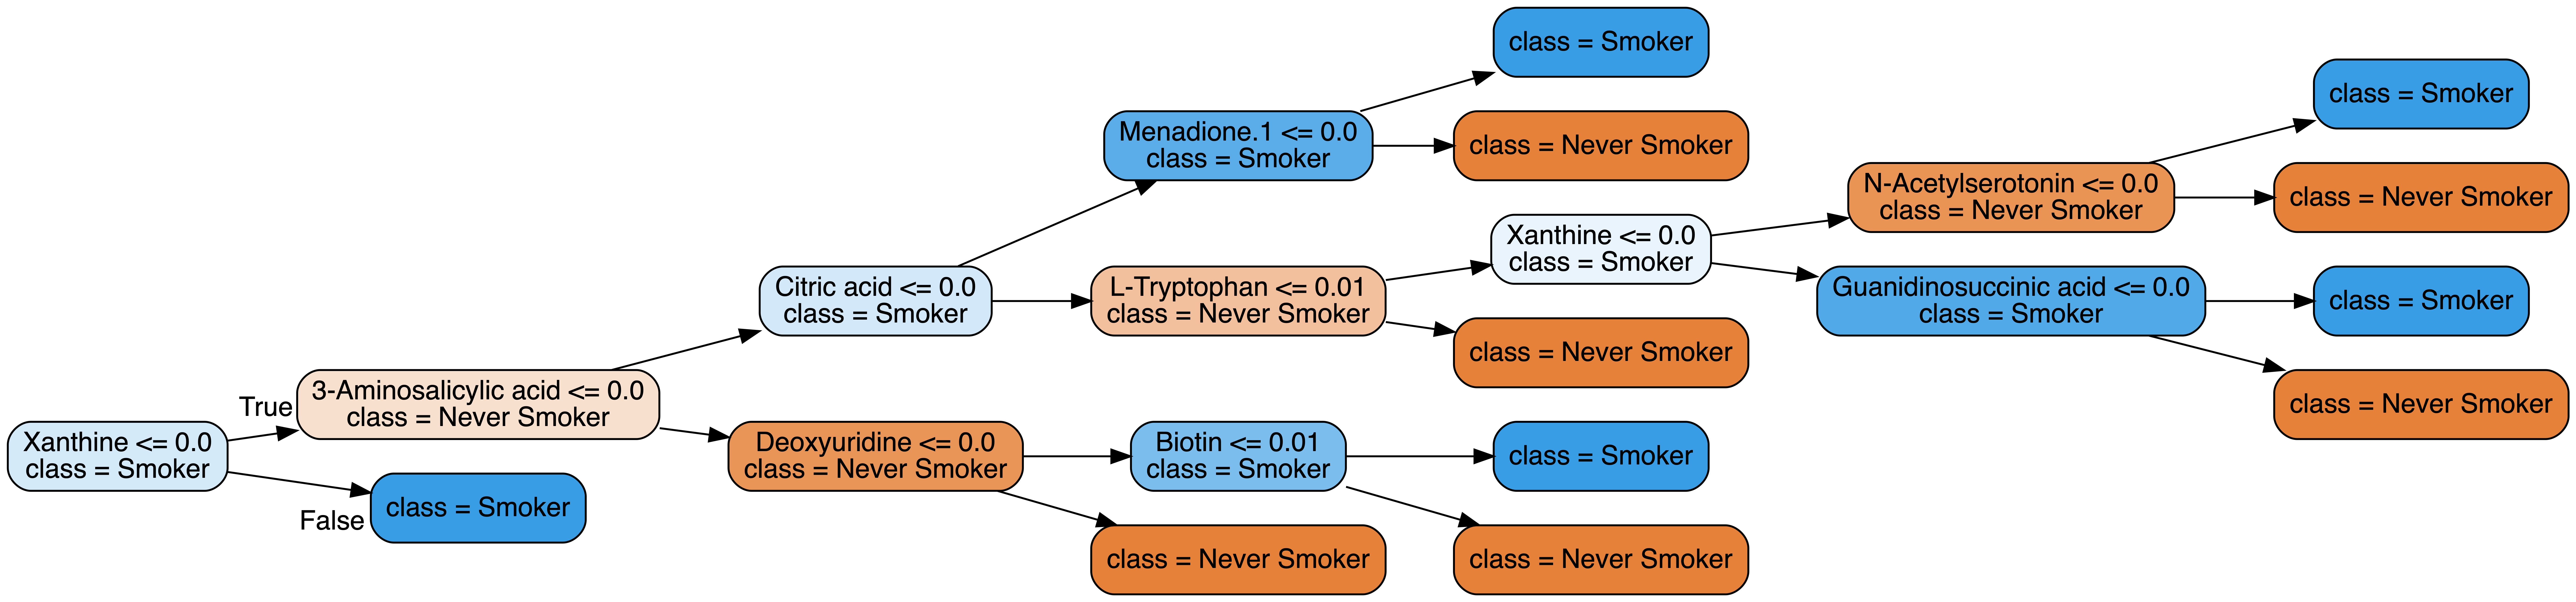

In [69]:
from subprocess import call
call(['dot', '-Tpng', 'MTBLS374_tree.dot', '-o', 'MTBLS374_tree_clean.png', '-Gdpi=600'])
plt.show()
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'MTBLS374_tree_clean.png')

NameError: name 'sessionInfo' is not defined